In [1]:
import getpass
import os
import torch
import numpy as np
from PIL import Image
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
#from skimage import transform
import sys
from sklearn.metrics import roc_curve, auc
import copy
from sklearn.metrics import f1_score
import torchvision.models as models
import re
import xml.etree.ElementTree as ET
import cv2
from matplotlib import rcParams, animation, rc
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *

#from display import read_image, draw_boxes, draw_grid, draw_text
#import display

In [2]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x
define_gpu_to_use()

Chosen GPU: 0


In [3]:
def load_raw_images(root,split):
    set_of_transforms = {}
    set_of_transforms['train'] = transforms.Compose(
        [transforms.RandomRotation(30),
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    set_of_transforms['test'] = transforms.Compose(
        [transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    set_of_transforms['validate'] = set_of_transforms['test']
    

    whole_dataset = torchvision.datasets.ImageFolder(root=root+'/'+split, transform=set_of_transforms[split])
    
    return whole_dataset   

def load_grayscale_images(root,split):
    set_of_transforms = {}
    set_of_transforms['train'] = transforms.Compose(
        [transforms.RandomRotation(30),
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(), 
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    set_of_transforms['test'] = transforms.Compose(
        [transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
    set_of_transforms['validate'] = set_of_transforms['test']
    

    whole_dataset = torchvision.datasets.ImageFolder(root=root+'/'+split, transform=set_of_transforms[split])
    
    return whole_dataset   

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

#color images
path_to_img_folder = '../color/60_20_20'
train_data = load_raw_images(path_to_img_folder,'train')
test_data = load_raw_images(path_to_img_folder,'test')
val_data = load_raw_images(path_to_img_folder,'validate')

#grayscale images
train_grayscale_data = load_grayscale_images(path_to_img_folder,'train')
test_grayscale_data = load_grayscale_images(path_to_img_folder,'test')
val_grayscale_data = load_grayscale_images(path_to_img_folder,'validate')

#segmented images
# path_to_segment_img_folder = '../segment/60_20_20segmented'
# train_segmented_data = load_grayscale_images(path_to_segment_img_folder,'train')
# test_segmented_data = load_raw_images(path_to_segment_img_folder,'test')
# val_segmented_data = load_raw_images(path_to_segment_img_folder,'validate')


label_names,label_indices = find_classes('../color/60_20_20/train')
label_names_dict = dict((v,k) for k,v in label_indices.items())
print ("Length of the train set:{}".format(len(train_data)))
print ("Length of the test set:{}".format(len(test_data)))
print ("Length of the validation set:{}".format(len(val_data)))
print (" ")
print ("The label names along with its corresponding key:{}".format(label_names_dict))

Length of the train set:16051
Length of the test set:6453
Length of the validation set:4264
 
The label names along with its corresponding key:{0: 'Apple_Frogeye_Spot', 1: 'Apple___Apple_scab', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_including_sour___Powdery_mildew', 6: 'Cherry_including_sour___healthy', 7: 'Corn_maize___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_maize___Common_rust_', 9: 'Corn_maize___Northern_Leaf_Blight', 10: 'Corn_maize___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_Black_Measles', 13: 'Grape___Leaf_blight_Isariopsis_Leaf_Spot', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_Citrus_greening', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper_bell___Bacterial_spot', 19: 'Pepper_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch',

In [4]:
#original images (RGB) data loader
train_loader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 84, num_workers = 3)
test_loader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size = 84, num_workers = 3)
val_loader = torch.utils.data.DataLoader(val_data, shuffle = True, batch_size = 84, num_workers = 3)

#grayscale data loader
train_grayscale_loader = torch.utils.data.DataLoader(train_grayscale_data, shuffle = True, batch_size = 84, num_workers = 3)
test_grayscale_loader = torch.utils.data.DataLoader(test_grayscale_data, shuffle = True, batch_size = 84, num_workers = 3)
val_grayscale_loader = torch.utils.data.DataLoader(val_grayscale_data, shuffle = True, batch_size = 84, num_workers = 3)

#segmented images data loader
# train_segmented_loader = torch.utils.data.DataLoader(train_segmented_data, shuffle = True, batch_size = 84, num_workers = 3)
# test_segmented_loader = torch.utils.data.DataLoader(test_segmented_data, shuffle = True, batch_size = 84, num_workers = 3)
# val_segmented_loader = torch.utils.data.DataLoader(val_segmented_data, shuffle = True, batch_size = 84, num_workers = 3)

#visualization
train_loader_vis = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = 1, num_workers = 3)

print ("Number of batches train set:{}".format(len(train_loader)))
print ("Number of batches test set:{}".format(len(test_loader)))
print ("Number of batches validation set:{}".format(len(val_loader)))

Number of batches train set:192
Number of batches test set:77
Number of batches validation set:51


# ResNet152

In [5]:
classification_model = models.resnet152(pretrained=True)
for param in classification_model.parameters():
    param.requires_grad = False
print (classification_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [8]:
fc_layer = torch.nn.Sequential(OrderedDict([
    ('fc_layer1',torch.nn.Linear(2048, 512)),
    ('relu',torch.nn.ReLU()),
    ('fc_layer2',torch.nn.Linear(512,38)),
    ('softmax',torch.nn.LogSoftmax(dim=1))]))
classification_model.fc = fc_layer

In [6]:
def train_classification_model(data_loader, model, criterion, optimizer, lr_decay, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        if lr_decay!=0:
            lr_decay.step()
        loss_sum = []; acc = 0
        for i in data_loader:
            input_img =i[0].cuda()
            target = i[1].cuda() 
            optimizer.zero_grad()
            predicted_output = model(input_img)
            loss = criterion(predicted_output, target)
            _,pred_out = torch.max(predicted_output,1)    
            loss.backward()
            optimizer.step()
            loss_sum.append(loss.item())
            acc+=torch.sum(pred_out==target.data)
        epoch_loss = sum(loss_sum)/len(loss_sum)
        epoch_accuracy = acc.item()/len(train_data)
        print ("epoch:"+str(epoch))
        print ("Loss:{:.6f}".format(epoch_loss))
        print ("Accuracy:{:.6f}".format(epoch_accuracy))
        print (" ")



In [7]:
#test models
def test_model(model,data_loader):
    model.eval()
    accuracy_list=[]
    with torch.no_grad():
        predicted_output_concat = np.zeros([84])
        target_concat = np.zeros([84])
        for i in data_loader:
            input_img=i[0].cuda()
            #print (input_img[0].shape)
            target=i[1]
            target=target.cuda()
            pred_output = model(input_img)
            eq = (target.data == torch.exp(pred_output).max(1)[1])
            pred_out = torch.exp(pred_output).max(1)[1]
            accuracy_list.append(eq.type_as(torch.FloatTensor()).mean())
            predicted_output_concat = np.concatenate((predicted_output_concat, pred_out.cpu().detach().numpy()), axis = 0)
            target_concat = np.concatenate((target_concat, target.cpu().detach().numpy()), axis = 0)
        print ("Test accuracy:{:.6f}".format(sum(accuracy_list)/len(accuracy_list)))
        print (target_concat)
        print (target_concat.shape)
        print (predicted_output_concat)
        print (predicted_output_concat.shape)
    print ("Macro F1 score:{}".format(f1_score(target_concat, predicted_output_concat, average="macro")))
    print ("Micro F1 score:{}".format(f1_score(target_concat, predicted_output_concat, average="micro")))


# Original Image (Color Dataset)

In [13]:
#train
criterion = torch.nn.NLLLoss()
classification_model = classification_model.cuda()
optimizer = torch.optim.Adam(classification_model.fc.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(classification_model.parameters(), lr=0.0001, momentum=0.9)
#lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_schedule=0
train_classification_model(train_loader, classification_model, criterion, optimizer,lr_schedule,10)

epoch:0
Loss:1.141607
Accuracy:0.703632
 
epoch:1
Loss:0.522162
Accuracy:0.841941
 
epoch:2
Loss:0.435762
Accuracy:0.866426
 
epoch:3
Loss:0.389703
Accuracy:0.879696
 
epoch:4
Loss:0.387888
Accuracy:0.879883
 
epoch:5
Loss:0.356950
Accuracy:0.890661
 
epoch:6
Loss:0.337718
Accuracy:0.896767
 
epoch:7
Loss:0.333405
Accuracy:0.893402
 
epoch:8
Loss:0.300424
Accuracy:0.905489
 
epoch:9
Loss:0.322061
Accuracy:0.898823
 


In [14]:
test_model(classification_model, val_loader)

Test accuracy:0.917382
[ 0.  0.  0. ... 25. 35. 35.]
(4348,)
[ 0.  0.  0. ... 25. 35. 35.]
(4348,)
Macro F1 score:0.8802099988795383
Micro F1 score:0.9188132474701012


In [15]:
test_model(classification_model, test_loader)

Test accuracy:0.916996
[ 0.  0.  0. ... 26. 15.  8.]
(6537,)
[ 0.  0.  0. ... 26. 15.  8.]
(6537,)
Macro F1 score:0.8842779094784589
Micro F1 score:0.9180052011626129


# ResNet on Grayscale Images

In [16]:
#train
criterion = torch.nn.NLLLoss()
classification_model = classification_model.cuda()
#optimizer = torch.optim.SGD(classification_model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(classification_model.fc.parameters(), lr=0.0001)
#lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_schedule=0
train_classification_model(train_grayscale_loader, classification_model, criterion, optimizer,lr_schedule,10)

epoch:0
Loss:1.069172
Accuracy:0.685876
 
epoch:1
Loss:0.883689
Accuracy:0.726559
 
epoch:2
Loss:0.834848
Accuracy:0.740141
 
epoch:3
Loss:0.767827
Accuracy:0.758146
 
epoch:4
Loss:0.751572
Accuracy:0.767180
 
epoch:5
Loss:0.721886
Accuracy:0.777210
 
epoch:6
Loss:0.706815
Accuracy:0.784188
 
epoch:7
Loss:0.692447
Accuracy:0.786368
 
epoch:8
Loss:0.667174
Accuracy:0.793782
 
epoch:9
Loss:0.641634
Accuracy:0.798393
 


In [17]:
test_model(classification_model, val_grayscale_loader)

Test accuracy:0.824930
[ 0.  0.  0. ... 35. 29. 18.]
(4348,)
[ 0.  0.  0. ... 35. 30. 19.]
(4348,)
Macro F1 score:0.7701589467540773
Micro F1 score:0.828656853725851


In [18]:
test_model(classification_model, test_grayscale_loader)

Test accuracy:0.825475
[ 0.  0.  0. ...  5. 12. 12.]
(6537,)
[ 0.  0.  0. ...  5. 12. 32.]
(6537,)
Macro F1 score:0.7687549429158826
Micro F1 score:0.8277497322931008


# AlexNet (Deep model)

In [8]:
class AlexNetModification(torch.nn.Module):
    def __init__(self):
        super(AlexNetModification, self).__init__()
        self.alex_model = models.alexnet(pretrained = True)

#         for param in self.alex_model.parameters():
#             param.requires_grad = False

#         for param in self.alex_model.features[10].parameters():
#             param.requires_grad = True
        
#         for param in self.alex_model.features[8].parameters():
#             param.requires_grad = True

#         for param in self.alex_model.features[6].parameters():
#             param.requires_grad = True

        self.modification_layer = torch.nn.Sequential(
                    torch.nn.Linear(1000, 400),
                    torch.nn.Linear(400,100),
                    torch.nn.Linear(100, 38),
                    )

        for param in self.modification_layer.parameters():
            param.requires_grad = True
            
        print (self.alex_model.parameters)
        print (self.alex_model.features[10])
        print (self.alex_model.features[8])
        print (self.alex_model.features[6])
                
    def forward(self,x):    
        out = self.alex_model.forward(x)
        out = self.modification_layer(out)
        return out
    
                
alex_net_model = AlexNetModification()

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2

In [9]:
alex_net_model

AlexNetModification(
  (alex_model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5)
      (1): Linear(in_features=92

In [10]:
print (alex_net_model.alex_model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [11]:
criterion = torch.nn.CrossEntropyLoss()
alex_net_model = alex_net_model.cuda()
#optimizer = torch.optim.SGD(alex_net_model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(alex_net_model.parameters(), lr=0.0001)
#lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_schedule=0
train_classification_model(train_loader, alex_net_model, criterion, optimizer,lr_schedule,10)

epoch:0
Loss:0.923813
Accuracy:0.734721
 
epoch:1
Loss:0.422012
Accuracy:0.871410
 
epoch:2
Loss:0.337084
Accuracy:0.894586
 
epoch:3
Loss:0.290700
Accuracy:0.906735
 
epoch:4
Loss:0.245942
Accuracy:0.921313
 
epoch:5
Loss:0.223931
Accuracy:0.927793
 
epoch:6
Loss:0.213380
Accuracy:0.931905
 
epoch:7
Loss:0.202306
Accuracy:0.935331
 
epoch:8
Loss:0.187806
Accuracy:0.941312
 
epoch:9
Loss:0.204385
Accuracy:0.934770
 


In [ ]:
#on freezing all the layers except 8,6,10, and with 2 linear additional layers got an accuracy 0.936806 (0.0001,e-5)
#on using the whole of alexnet model with three linear models - 0.945854 (0.0001,e-5)
#freezing the layers except 8,6,10 with 3 linear - 0.937061 (0.0001,e-5)
# without lr decay and 3 layers, frozen, two addn linear  0.95 (lr=0.0001,e-5)
#with 0.001 lr and no lr decay and 3 layers, frozen, two addn linear 0.8767
# with lr=0.0001 and no lr decay and 3 layers, frozen, two addn linear (e-10) - 0.96

In [11]:
test_model(alex_net_model,val_loader)

Test accuracy:0.970690
[ 0.  0.  0. ... 12.  9. 24.]
(4348,)
[ 0.  0.  0. ... 12.  9. 24.]
(4348,)
Macro F1 score:0.9599181289202741
Micro F1 score:0.9714811407543699


In [12]:
test_model(alex_net_model,test_loader)

Test accuracy:0.970590
[ 0.  0.  0. ... 10. 15. 30.]
(6537,)
[ 0.  0.  0. ... 10. 15. 30.]
(6537,)
Macro F1 score:0.9602992250497271
Micro F1 score:0.9709346795165978


# AlexNet on grayscale images

In [15]:
criterion = torch.nn.CrossEntropyLoss()
alex_net_model = alex_net_model.cuda()
#optimizer = torch.optim.SGD(alex_net_model.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(alex_net_model.parameters(), lr=0.0001)
#lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
lr_schedule=0
train_classification_model(train_grayscale_loader, alex_net_model, criterion, optimizer,lr_schedule,10)

epoch:0
Loss:0.699053
Accuracy:0.781696
 
epoch:1
Loss:0.597109
Accuracy:0.813096
 
epoch:2
Loss:0.551820
Accuracy:0.827550
 
epoch:3
Loss:0.527841
Accuracy:0.838577
 
epoch:4
Loss:0.497264
Accuracy:0.847548
 
epoch:5
Loss:0.454809
Accuracy:0.857953
 
epoch:6
Loss:0.446085
Accuracy:0.855772
 
epoch:7
Loss:0.420812
Accuracy:0.868731
 
epoch:8
Loss:0.417020
Accuracy:0.868419
 
epoch:9
Loss:0.395322
Accuracy:0.876207
 


In [16]:
test_model(alex_net_model,val_grayscale_loader)

Test accuracy:0.901902
[ 0.  0.  0. ... 12. 33. 29.]
(4348,)
[ 0.  0.  0. ... 12. 37. 32.]
(4348,)
Macro F1 score:0.8714652780840568
Micro F1 score:0.9036338546458141


In [17]:
test_model(alex_net_model,test_grayscale_loader)

Test accuracy:0.901092
[ 0.  0.  0. ... 30.  4. 24.]
(6537,)
[ 0.  0.  0. ... 30.  4. 24.]
(6537,)
Macro F1 score:0.8702729746491858
Micro F1 score:0.9024017133241549


# Visualization of output of various layers in alex net (Deep)

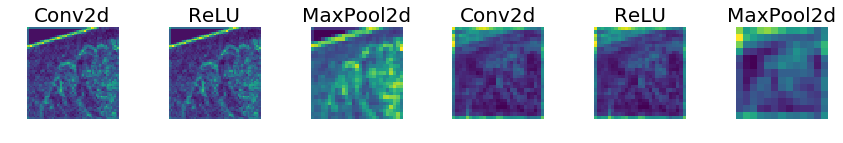

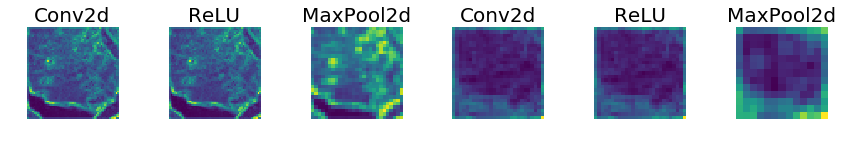

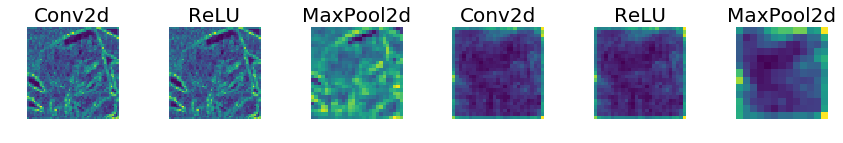

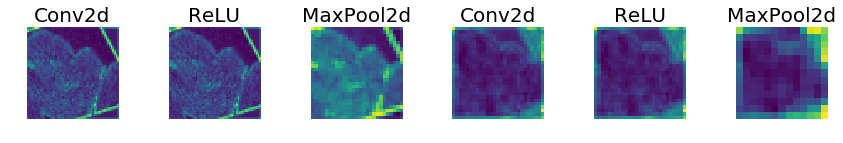

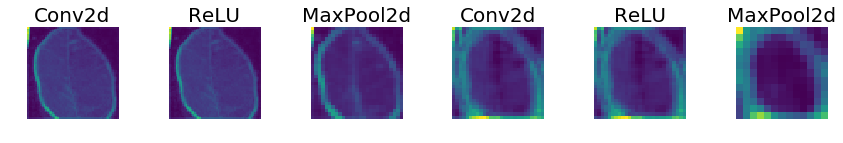

In [14]:
model_list = list(alex_net_model.alex_model.features)
def conversion_to_grayscale(im):

    im = torch.sum(im, dim=0)
    im = torch.div(im, im.shape[0])
    return im

def visualization_layers(img, models):
    final_vis = []
    vis_layers_names = []
    for current_layer in models[:6]:
        #print (current_layer)
        #print (img.shape)
        img = img.cuda()
        img = current_layer(img)
        final_vis.append(img)
        vis_layers_names.append(str(current_layer))
    final_images = []
    for i in final_vis:
        i = i.squeeze(0)
        grayscale_img = conversion_to_grayscale(i)
        #print (grayscale_img.shape)
        final_images.append(grayscale_img.data.cpu().numpy())
        
    fig = plt.figure()
    plt.rcParams["figure.figsize"] = (25, 40)


    for i in range(len(final_images)):
        a = fig.add_subplot(20,10,i+1)
        #print (final_images[i].shape)
        imgplot = plt.imshow(final_images[i])
        plt.axis('off')
        a.set_title(vis_layers_names[i].partition('(')[0], fontsize=20)

    plt.savefig('visualization_layers.jpg', bbox_inches='tight')
count_images=0    
for i in train_loader_vis: 
    count_images+=1
    if count_images>5:
        break
    #print (i[0].shape)
    visualization_layers(i[0], model_list)

# AlexNet (Shallow model)

In [19]:
class AlexNetModification_shallow(torch.nn.Module):
    def __init__(self):
        super(AlexNetModification_shallow, self).__init__()
        self.alex_model = models.alexnet(pretrained = True)

        for param in self.alex_model.parameters():
            param.requires_grad = False

        for param in self.alex_model.features[10].parameters():
            param.requires_grad = True
        
        for param in self.alex_model.features[8].parameters():
            param.requires_grad = True

        for param in self.alex_model.features[6].parameters():
            param.requires_grad = True

        self.modification_layer = torch.nn.Sequential(
                    torch.nn.Linear(1000, 400),
                    torch.nn.Linear(400,100),
                    torch.nn.Linear(100, 38),
                    )

        for param in self.modification_layer.parameters():
            param.requires_grad = True
            
        print (self.alex_model.parameters)
        print (self.alex_model.features[10])
        print (self.alex_model.features[8])
        print (self.alex_model.features[6])
                
    def forward(self,x):    
        out = self.alex_model.forward(x)
        out = self.modification_layer(out)
        return out
    
                
alex_net_model_shallow = AlexNetModification_shallow()

<bound method Module.parameters of AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2

# Colored images

In [21]:
criterion = torch.nn.CrossEntropyLoss()
alex_net_model_shallow = alex_net_model_shallow.cuda()
optimizer = torch.optim.SGD(alex_net_model_shallow.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(alex_net_model_shallow.parameters(), lr=0.0001)
lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#lr_schedule=0
train_classification_model(train_loader, alex_net_model_shallow, criterion, optimizer,lr_schedule,10)

epoch:0
Loss:0.659029
Accuracy:0.799327
 
epoch:1
Loss:0.487991
Accuracy:0.849293
 
epoch:2
Loss:0.446339
Accuracy:0.862438
 
epoch:3
Loss:0.363033
Accuracy:0.882998
 
epoch:4
Loss:0.349222
Accuracy:0.891969
 
epoch:5
Loss:0.221582
Accuracy:0.933524
 
epoch:6
Loss:0.176262
Accuracy:0.942994
 
epoch:7
Loss:0.173980
Accuracy:0.942994
 
epoch:8
Loss:0.167639
Accuracy:0.944988
 
epoch:9
Loss:0.154594
Accuracy:0.950720
 


In [22]:
test_model(alex_net_model_shallow,val_loader)

Test accuracy:0.964752
[ 0.  0.  0. ... 24.  3. 32.]
(4348,)
[ 0.  0.  0. ... 24.  3. 32.]
(4348,)
Macro F1 score:0.9541000342806962
Micro F1 score:0.9652713891444342


In [23]:
test_model(alex_net_model_shallow,test_loader)

Test accuracy:0.962484
[ 0.  0.  0. ... 24. 35.  8.]
(6537,)
[ 0.  0.  0. ... 24. 35.  8.]
(6537,)
Macro F1 score:0.951509158550904
Micro F1 score:0.9629799602264035


# Grayscale images

In [24]:
criterion = torch.nn.CrossEntropyLoss()
alex_net_model_shallow = alex_net_model_shallow.cuda()
optimizer = torch.optim.SGD(alex_net_model_shallow.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(alex_net_model.parameters(), lr=0.0001)
lr_schedule = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
#lr_schedule=0
train_classification_model(train_grayscale_loader, alex_net_model_shallow, criterion, optimizer,lr_schedule,10)

epoch:0
Loss:3.424977
Accuracy:0.097564
 
epoch:1
Loss:3.350738
Accuracy:0.094574
 
epoch:2
Loss:3.342760
Accuracy:0.099994
 
epoch:3
Loss:3.320571
Accuracy:0.104978
 
epoch:4
Loss:3.208642
Accuracy:0.140054
 
epoch:5
Loss:1.635454
Accuracy:0.538471
 
epoch:6
Loss:1.016892
Accuracy:0.694723
 
epoch:7
Loss:0.856222
Accuracy:0.734783
 
epoch:8
Loss:0.782893
Accuracy:0.758021
 
epoch:9
Loss:0.733356
Accuracy:0.770108
 


In [25]:
test_model(alex_net_model_shallow,val_grayscale_loader)

Test accuracy:0.820159
[ 0.  0.  0. ... 12. 31. 13.]
(4348,)
[ 0.  0.  0. ... 12. 31. 13.]
(4348,)
Macro F1 score:0.7634543752251706
Micro F1 score:0.8235970561177552


In [26]:
test_model(alex_net_model_shallow,test_grayscale_loader)

Test accuracy:0.815944
[0. 0. 0. ... 0. 3. 3.]
(6537,)
[0. 0. 0. ... 0. 3. 3.]
(6537,)
Macro F1 score:0.7589396454683709
Micro F1 score:0.818418234664219
